<a href="https://colab.research.google.com/github/Roy-Subhankar/SGEMM-GPU-Kernel-Performance/blob/main/Subhankar_Roy_SGEMM_GPU_Kernel_Performance_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the running times for multiplying two 2048 x 2048 matrices using a GPU OpenCL SGEMM kernel with varying parameters (using the library 'CLTune'). </u></b>

## <b> Problem Description </b>

### This data set measures the running time of a matrix-matrix product $A*B = C$, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 241600 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds*.

### There are 14 parameter, the first 10 are ordinal and can only take up to 4 different powers of two values, and the 4 last variables are binary. Out of 1327104 total parameter combinations, only 241600 are feasible (due to various kernel constraints). This data set contains the results for all these feasible combinations.

### The experiment was run on a desktop workstation running Ubuntu 16.04 Linux with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB GF580 GTX-1.5GB GPU. We use the 'gemm_fast' kernel from the automatic OpenCL kernel tuning library 'CLTune' ([Web Link]).

#### * Note: for this kind of data sets it is usually better to work with the logarithm of the running times 


## <b> Data Description </b>

### <b>Attribute Information: </b>

### Independent variables:
* ### MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
* ### KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
* ### MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)
* ### MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)
* ### KWI: kernel loop unrolling factor: {2, 8} (integer)
* ### VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
* ### STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
* ### SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)

### Output:
* ### Run1, Run2, Run3, Run4: performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.simplefilter("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Supervised ML - Regression Project/sgemm_product.csv')

In [ ]:
dataset.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


In [ ]:
dataset.tail()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.96,17.77,17.77,17.77
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.04,36.03,36.04,36.03
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.28,34.82,35.27,35.27
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.43,28.49,28.44,28.45
241599,128,128,32,32,32,32,32,8,4,4,1,1,1,1,17.94,17.79,17.77,17.77


In [ ]:
dataset.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.647852,217.579536,217.532756,217.527669
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,369.012422,368.677309,368.655118,368.677413
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.290000,13.250000,13.360000,13.370000
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.660000,40.710000,40.660000,40.640000
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.825000,69.930000,69.790000,69.820000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.530000,228.310000,228.320000,228.320000
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3339.630000,3375.420000,3397.080000,3361.710000


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   MWG        241600 non-null  int64  
 1   NWG        241600 non-null  int64  
 2   KWG        241600 non-null  int64  
 3   MDIMC      241600 non-null  int64  
 4   NDIMC      241600 non-null  int64  
 5   MDIMA      241600 non-null  int64  
 6   NDIMB      241600 non-null  int64  
 7   KWI        241600 non-null  int64  
 8   VWM        241600 non-null  int64  
 9   VWN        241600 non-null  int64  
 10  STRM       241600 non-null  int64  
 11  STRN       241600 non-null  int64  
 12  SA         241600 non-null  int64  
 13  SB         241600 non-null  int64  
 14  Run1 (ms)  241600 non-null  float64
 15  Run2 (ms)  241600 non-null  float64
 16  Run3 (ms)  241600 non-null  float64
 17  Run4 (ms)  241600 non-null  float64
dtypes: float64(4), int64(14)
memory usage: 33.2 MB


In [ ]:
dataset.nunique()

MWG              4
NWG              4
KWG              2
MDIMC            3
NDIMC            3
MDIMA            3
NDIMB            3
KWI              2
VWM              4
VWN              4
STRM             2
STRN             2
SA               2
SB               2
Run1 (ms)    58161
Run2 (ms)    58269
Run3 (ms)    58264
Run4 (ms)    58154
dtype: int64

In [ ]:
dataset.isnull().sum()

MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
KWI          0
VWM          0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
Run3 (ms)    0
Run4 (ms)    0
dtype: int64

In [ ]:
dataset['avg_runtime']=(dataset['Run1 (ms)']+dataset['Run2 (ms)']+dataset['Run3 (ms)']+dataset['Run4 (ms)'])/4
dataset.drop(['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'],axis=1,inplace=True)

In [ ]:
dataset.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,avg_runtime
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,118.6625


<function matplotlib.pyplot.show>

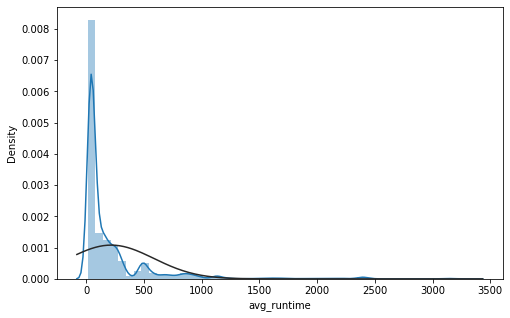

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(dataset['avg_runtime'], fit=norm)
plt.show

so the dependent variable is positively skewed.

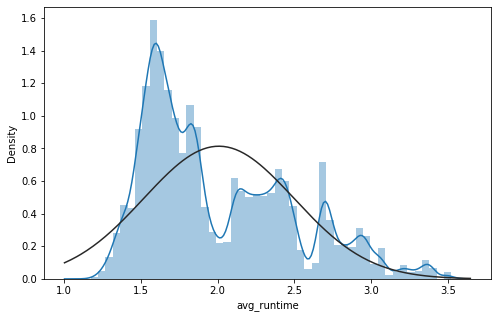

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(np.log10(dataset['avg_runtime']), fit=norm)
plt.show()

In [ ]:
dataset['avglog_runtime']=np.log10(dataset['avg_runtime'])
dataset.drop(['avg_runtime'],axis=1,inplace=True)

In [ ]:
ind_variables=dataset.drop(['avglog_runtime'],axis=1)

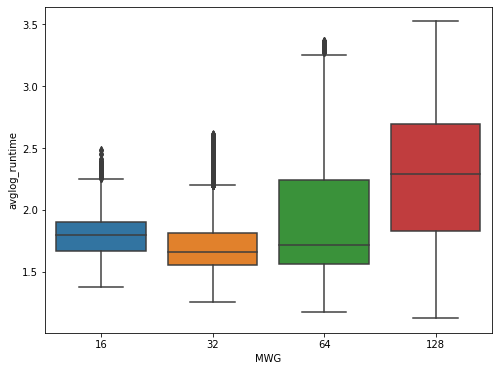

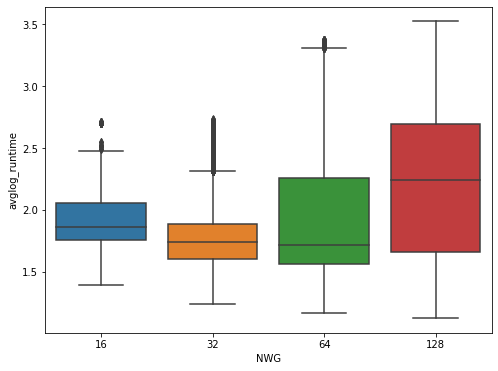

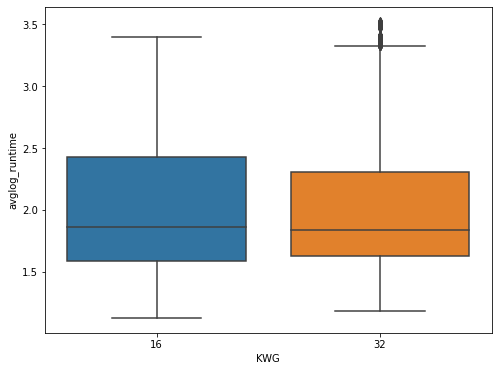

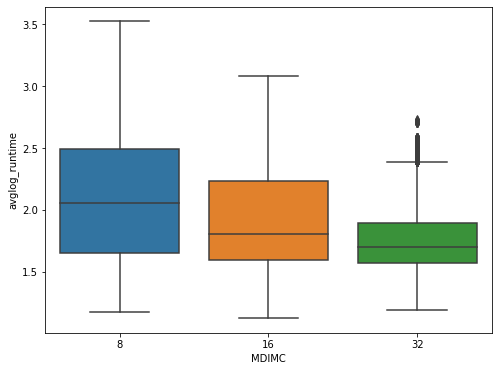

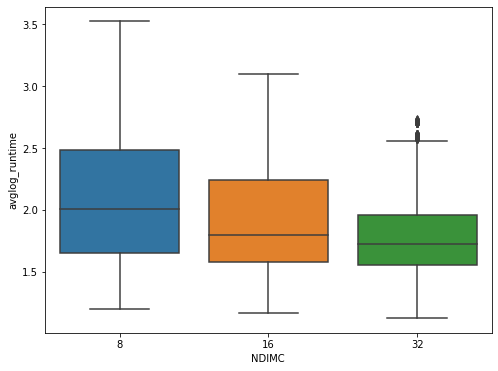

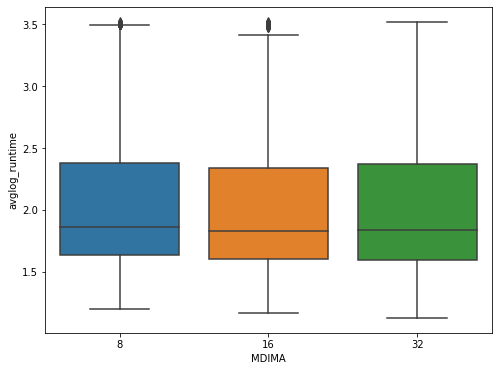

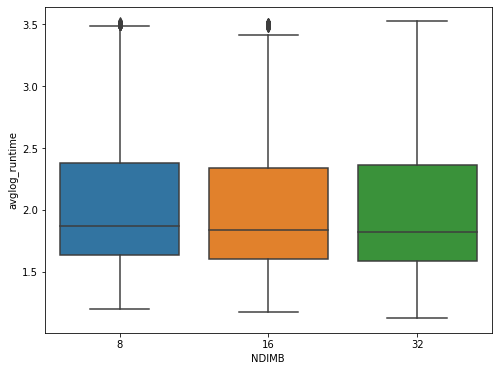

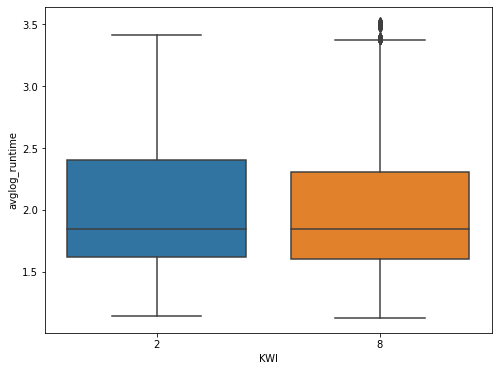

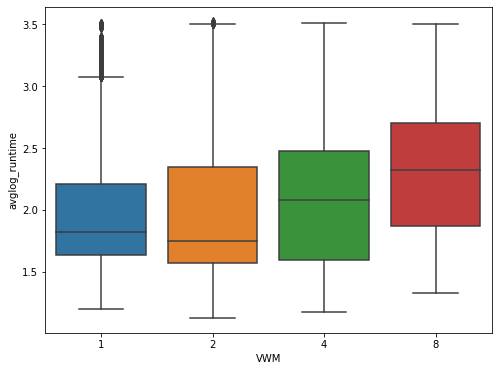

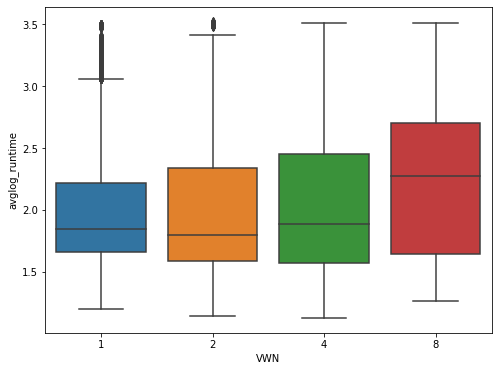

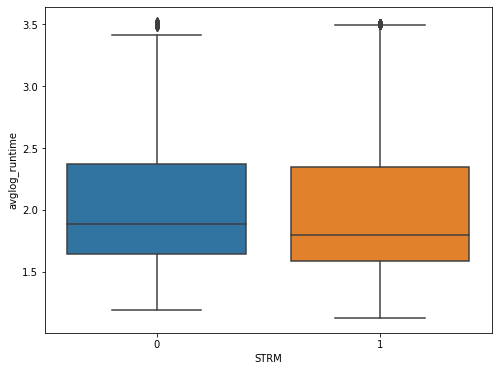

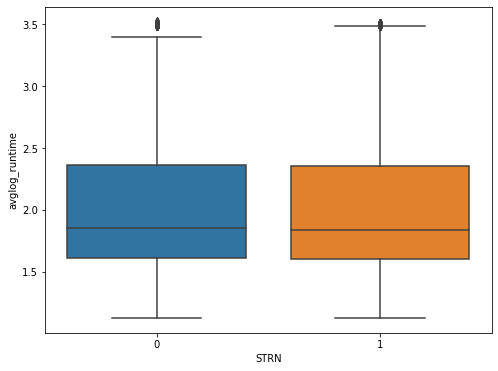

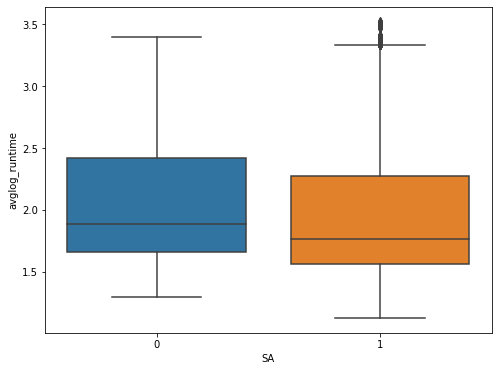

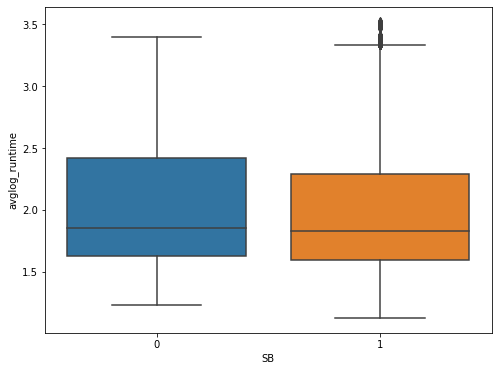

In [ ]:
for col in ind_variables.describe().columns:
  plt.figure(figsize=(8,6))
  sns.boxplot(ind_variables[col],dataset['avglog_runtime'])
  plt.xlabel(col)
  plt.show()

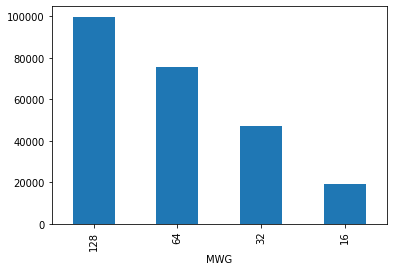

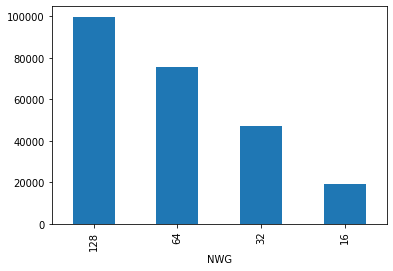

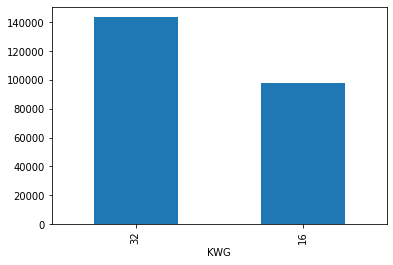

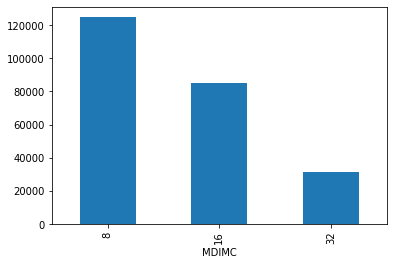

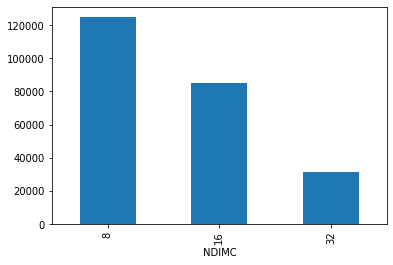

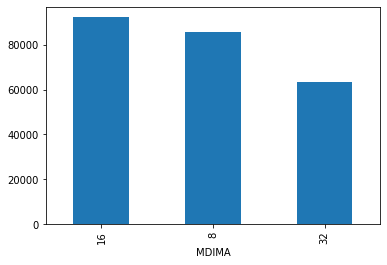

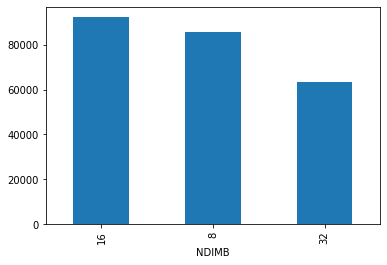

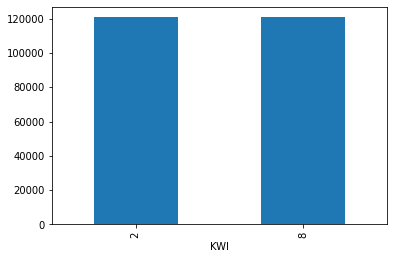

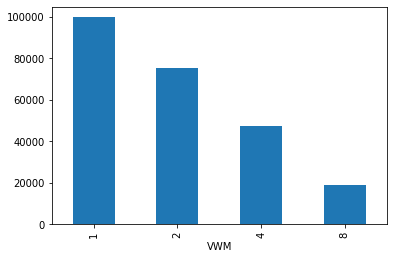

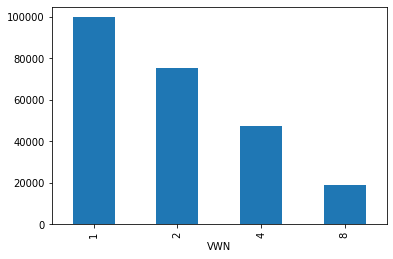

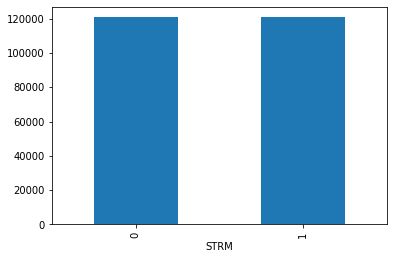

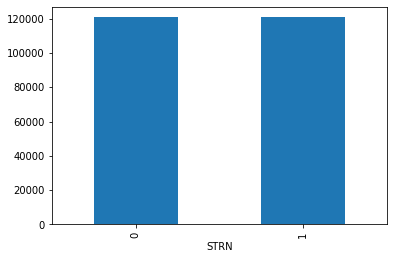

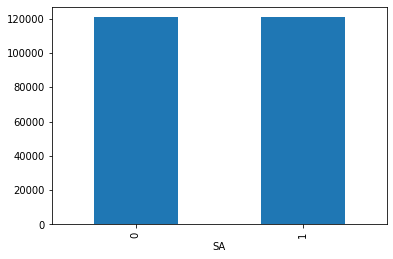

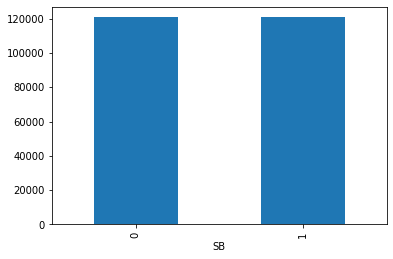

In [ ]:
for col in ind_variables.describe().columns:
  ind_variables[col].value_counts().plot(kind='bar')
  plt.xlabel(col)
  plt.show()

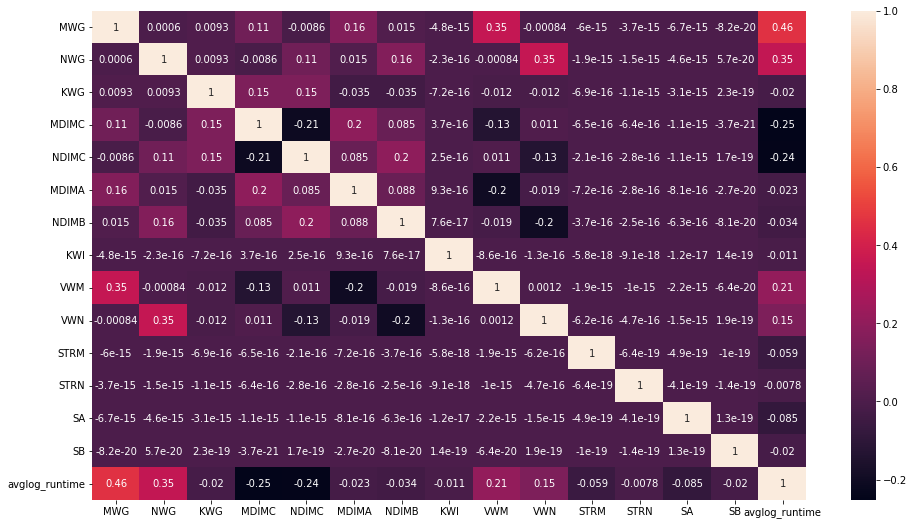

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(dataset.corr(), annot=True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame() # create a DataFrame where we will add feature and its respective vif value
    vif["variables"] = X.columns # Variable feature in vif dataframe will have columns from X i.e. input
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] # vif value for that column 
    return(vif)

In [ ]:
calc_vif(dataset[[i for i in dataset.describe().columns if i not in ['avglog_runtime']]])

,variables,VIF
0,MWG,5.570888
1,NWG,5.570888
2,KWG,9.434536
3,MDIMC,4.761904
4,NDIMC,4.761904
5,MDIMA,4.822777
6,NDIMB,4.822777
7,KWI,3.479154
8,VWM,3.097287
9,VWN,3.097287


In [ ]:
ind_variables.duplicated().sum()

0

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset[dataset.columns[:-1]],dataset[dataset.columns[-1]],test_size = 0.3, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(169120, 14) (169120,)
(72480, 14) (72480,)


In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.5615411506050432

In [ ]:
reg.intercept_

1.8365320094331734

In [ ]:
reg.coef_

array([ 5.80716891e-03,  4.58389356e-03,  5.40639825e-03, -2.46726954e-02,
       -2.37841297e-02,  1.04213653e-04, -9.09917116e-05, -1.83423647e-03,
       -3.72977751e-03, -1.02602692e-02, -5.73659748e-02, -7.45068237e-03,
       -8.25239573e-02, -2.02161948e-02])

In [ ]:
y_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

MSE  = mean_squared_error(10**(y_test), 10**(y_pred))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 85404.44954567794
RMSE : 292.2403968408166
R2 : 0.3748145090934303
Adjusted R2 :  0.3746937253099114


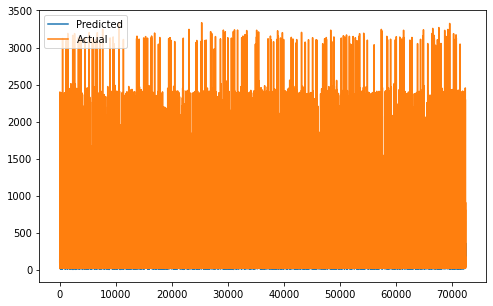

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(10**(y_pred))
plt.plot(np.array(10**(y_test)))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100, 0.0014]},
             scoring='neg_mean_squared_error')

In [ ]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-08}

Using  {'alpha': 1e-08}  the negative mean squared error is:  -0.10541574690851374


In [ ]:
y_pred_lasso = lasso_regressor.predict(X_test)

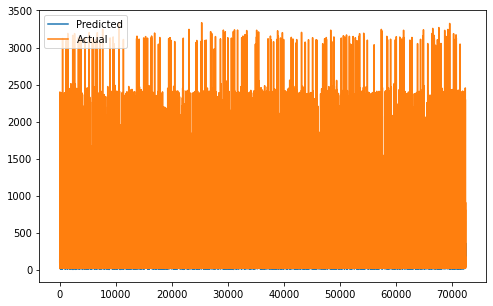

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(10**(y_pred_lasso))
plt.plot(10**(np.array(y_test)))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_lasso))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_lasso))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_lasso)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 85404.44765188317
RMSE : 292.2403936006848
R2 : 0.3748145229565606
Adjusted R2 :  0.37469373917572


In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             scoring='neg_mean_squared_error')

In [ ]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 10}

Using  {'alpha': 10}  the negative mean squared error is:  -0.10541068274308595


In [ ]:
y_pred_ridge = ridge_regressor.predict(X_test)

In [ ]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_ridge))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_ridge))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_ridge)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 85403.7791109213
RMSE : 292.23924977819337
R2 : 0.3748194168714756
Adjusted R2 :  0.37469863403612336


In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()

In [ ]:
tree.fit(X_train,y_train)

DecisionTreeRegressor()

In [ ]:
y_pred=tree.predict(X_test)


In [ ]:
r2_score(y_test, y_pred)


0.9988767504438986

In [ ]:
print("Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))


Adjusted R2 :  0.9988765334357734


Text(0, 0.5, 'Predicted')

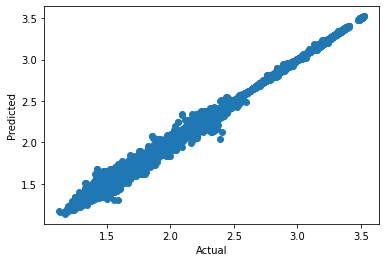

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

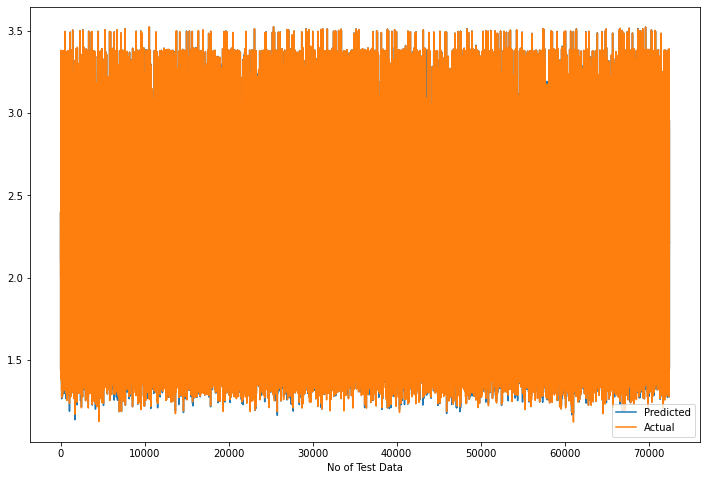

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_pred)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.xlabel('No of Test Data')
plt.show()

In [ ]:
tree.feature_importances_

array([0.28705256, 0.23556268, 0.01365745, 0.17204196, 0.20259731,
       0.00118223, 0.00116256, 0.0039565 , 0.01442181, 0.00784414,
       0.01250544, 0.00139851, 0.02843919, 0.01817764])

In [ ]:
features = ind_variables.columns
importances = tree.feature_importances_
indices = np.argsort(importances)

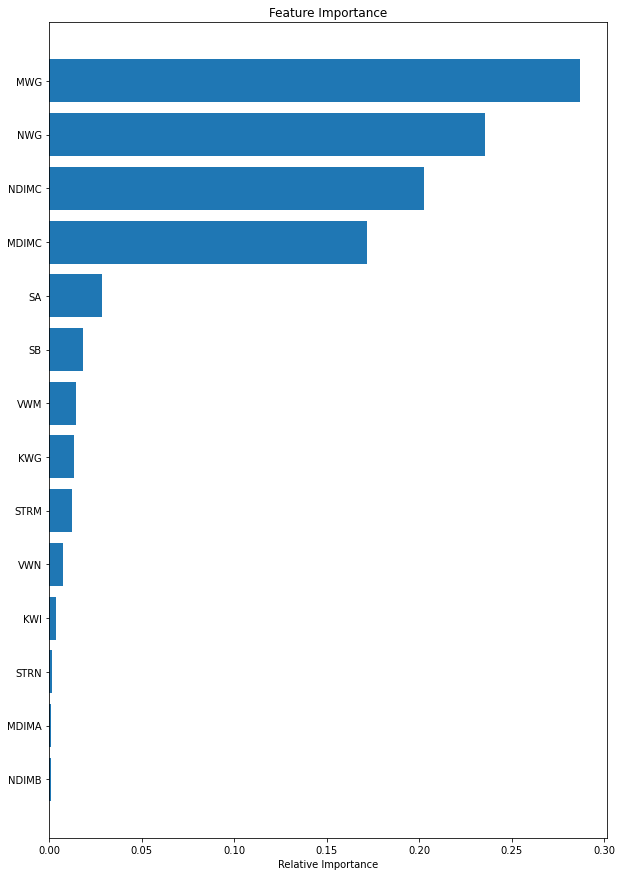

In [ ]:
plt.figure(figsize=(10,15))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices],  align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()